In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# Model prototyping

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will affect the CNN more than the regression, because
the small number of samples influences how well the specific architecture will perform. Regardless I will press on and continue this testing. 

Both will use mean squared error as their loss function, unfortunately this means that I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

Much like how in regression we want to include multiple days of information for prediction,  it may also be benefitial to convolve multiple frames together for the CNN?

In [2]:

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    print(y_true.shape, y_naive.shape, y_predict.shape)
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def normalize_Xy_splits(splits, feature_range=(0., 0.5), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = (0, 0.5)
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    for i in range(1, X_train.shape[0]+1):
        # find the minima and maxima of all features for all countries, ranging up to current frame and 
        # each time step in the frame. 
        up_to_current_frame_min = X_train[:i,:,:,:].min((0,1,2))
        up_to_current_frame_max = X_train[:i,:,:,:].max((0,1,2))
        latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        if i == 1:
            frame_min_array = latest_min_array
            frame_max_array = latest_max_array
        else:
            frame_min_array = np.concatenate((frame_min_array, 
                                                   latest_min_array)
                                                  ,axis=0)
            frame_max_array = np.concatenate((frame_max_array, 
                                                   latest_max_array)
                                                  ,axis=0)

    # frame_min_array = np.tile(frame_min_array, (1, n_countries, 1, 1))
    # frame_max_array = np.tile(frame_max_array, (1, n_countries, 1, 1))

    minmax_denominator = (frame_max_array-frame_min_array)
    minmax_denominator[np.where(minmax_denominator==0)]=1
    X_train_scaled = (max_-min_)*(X_train - frame_min_array) / minmax_denominator
    # Use the latest min and max for test scaling.

    latest_minmax_denominator = latest_max_array - latest_min_array
    latest_minmax_denominator[np.where(latest_minmax_denominator==0)] = 1
    X_validate_scaled = (max_- min_)*((X_validate - np.tile(latest_min_array,(n_validation_frames,1,1,1)))
                                        / np.tile(latest_minmax_denominator,(n_validation_frames,1,1,1)))
    X_test_scaled = (max_- min_)*((X_test - np.tile(latest_min_array,(n_test_frames,1,1,1))) 
                                        / np.tile(latest_minmax_denominator,(n_test_frames,1,1,1)))
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 

    train_norm_arrays =  (frame_max_array, frame_min_array, minmax_denominator)
    validate_and_test_norm_arrays = (latest_max_array,latest_min_array,latest_minmax_denominator)

    return scaled_splits, train_norm_arrays, validate_and_test_norm_arrays

def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None

should have been average/taking min max over countries as well as time. 

be sure to check the definition of y when multiple countries. I think this is the definition from when using chronological data.

Things that have been discussed with mike that might need to be changed. predicting log(y) as opposed to y. 
using MAE instead of MSE. 
using pooling or not. 
filter numbers. 
Using one country, one feature. 

In [3]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [4]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)
# data = global_data
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# data.loc[:, 'time_index'] += 1

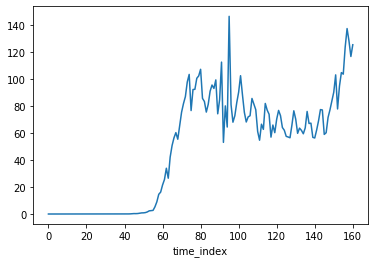

In [5]:
per_country_plot(data, 'new_cases_per_million',legend=False)

# CNN model


Late to the party of why CNN model misbehaves sometimes; problem lies in the activation functions + dense layers; most common complication is that the output layer's weight is w<=0, meaning that upon multiplication with ReLU, it can only provide 0. 

In [6]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 1:]
model_data =  model_data#.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = model_data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [7]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
# if need to supply folds for sklearn CV regression functions.
(X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
(train_indices, validate_indices, test_indices) = indices

scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = splits

X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0], X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0], X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0], X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_test_model = y_cnn_test.ravel()



X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


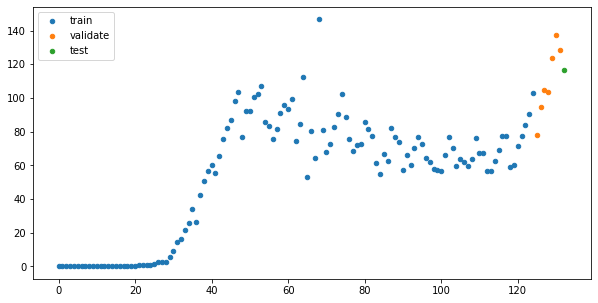

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(range(len(X)), X[:, 0, -1, new_cases_index], s=40, color='r')
ax.scatter(range(len(X_cnn_train)), X_cnn_train[:,0,-1,new_cases_index], s=20, label='train')
ax.scatter(range(len(X_cnn_train), len(X_cnn_train)+len(X_cnn_validate)), X_cnn_validate[:,0,-1,new_cases_index], s=20, label='validate')
ax.scatter(range(len(X_cnn_train)+len(X_cnn_validate), len(X)), X_cnn_test[:,0,-1,new_cases_index], s=20, label='test')
# ax.plot(np.log(data.new_cases_per_million.values[start_date-1:-1]+1), color='k', alpha=0.2)
# ax.plot(y, color='k')
plt.legend()
_ = plt.show()

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

In [9]:
epochs = 100
learning_rate = 0.001
kernel = 4
N = 8
FC = 8
batch_size = X_cnn_train.shape[0]

f1, f2 = 64, 8
k1, k2 = 4, 4

cnn_model = Sequential()
# kernel_initializer0=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
#                 kernel_constraint=non_neg(),
#                  activation='relu',
#                 kernel_initializer=kernel_initializer0
                )
         )

# cnn_model.add(A/veragePooling1D(pool_size=2))
# cnn_model.add(Activation('relu'))
# kernel_initializer1=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 use_bias=False,
#                  kernel_constraint=non_neg(),

#                  activation='relu',
#                 kernel_initializer=kernel_initializer1
#                   use_bias=False
                )
         )


# cnn_model.add(AveragePooling1D(pool_size=2))
# cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())

# kernel_initializer2=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=2,
#                                 dtype=float)

cnn_model.add(Dense(cnn_model.output.shape[1], 
#                 activation='relu',
                use_bias=False,
#                  kernel_constraint=non_neg(),
#                 kernel_initializer=kernel_initializer2
               )
         )

kernel_initializer=RandomUniform(minval=0.0, 
                                 maxval= 1.0,
                                 seed=0,
                                dtype=float)

cnn_model.add(Dense(1, 
                    activation='relu',
                    use_bias=False,
                     kernel_constraint=non_neg(),
                    kernel_initializer=kernel_initializer
                   ))
cnn_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


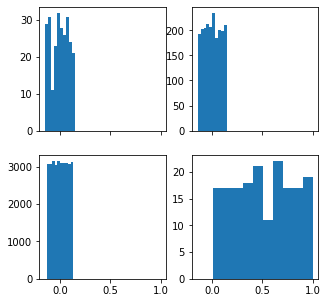

In [10]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [11]:
X_cnn_train_model.shape

(125, 28, 1)

In [12]:
history = cnn_model.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=1)

Train on 125 samples, validate on 7 samples
Epoch 1/1000
125/125 [==============================] - 0s 1ms/sample - loss: 519.9940 - val_loss: 630.7574
Epoch 2/1000
125/125 [==============================] - 0s 72us/sample - loss: 661.6136 - val_loss: 1443.1393
Epoch 3/1000
125/125 [==============================] - 0s 80us/sample - loss: 485.5873 - val_loss: 2356.8257
Epoch 4/1000
125/125 [==============================] - 0s 80us/sample - loss: 568.0947 - val_loss: 2345.3381
Epoch 5/1000
125/125 [==============================] - 0s 80us/sample - loss: 563.4468 - val_loss: 1796.1569
Epoch 6/1000
125/125 [==============================] - 0s 72us/sample - loss: 480.3408 - val_loss: 1200.6556
Epoch 7/1000
125/125 [==============================] - 0s 72us/sample - loss: 449.1045 - val_loss: 836.8572
Epoch 8/1000
125/125 [==============================] - 0s 64us/sample - loss: 480.2836 - val_loss: 744.3428
Epoch 9/1000
125/125 [==============================] - 0s 64us/sample - loss: 4

125/125 [==============================] - 0s 64us/sample - loss: 143.9465 - val_loss: 208.4931
Epoch 76/1000
125/125 [==============================] - 0s 72us/sample - loss: 143.2782 - val_loss: 207.3973
Epoch 77/1000
125/125 [==============================] - 0s 72us/sample - loss: 142.6080 - val_loss: 200.7768
Epoch 78/1000
125/125 [==============================] - 0s 72us/sample - loss: 141.8799 - val_loss: 193.1121
Epoch 79/1000
125/125 [==============================] - 0s 64us/sample - loss: 141.2446 - val_loss: 189.2622
Epoch 80/1000
125/125 [==============================] - 0s 72us/sample - loss: 140.6449 - val_loss: 190.4860
Epoch 81/1000
125/125 [==============================] - 0s 64us/sample - loss: 139.9919 - val_loss: 193.8941
Epoch 82/1000
125/125 [==============================] - 0s 64us/sample - loss: 139.3919 - val_loss: 194.9754
Epoch 83/1000
125/125 [==============================] - 0s 112us/sample - loss: 138.8407 - val_loss: 191.6309
Epoch 84/1000
125/125 [

Epoch 150/1000
125/125 [==============================] - 0s 64us/sample - loss: 117.1535 - val_loss: 145.1580
Epoch 151/1000
125/125 [==============================] - 0s 64us/sample - loss: 116.9738 - val_loss: 144.8804
Epoch 152/1000
125/125 [==============================] - 0s 56us/sample - loss: 116.7970 - val_loss: 144.4605
Epoch 153/1000
125/125 [==============================] - 0s 64us/sample - loss: 116.6225 - val_loss: 144.0187
Epoch 154/1000
125/125 [==============================] - 0s 64us/sample - loss: 116.4507 - val_loss: 143.6973
Epoch 155/1000
125/125 [==============================] - 0s 72us/sample - loss: 116.2812 - val_loss: 143.4912
Epoch 156/1000
125/125 [==============================] - 0s 96us/sample - loss: 116.1140 - val_loss: 143.2656
Epoch 157/1000
125/125 [==============================] - 0s 88us/sample - loss: 115.9493 - val_loss: 142.9318
Epoch 158/1000
125/125 [==============================] - 0s 88us/sample - loss: 115.7870 - val_loss: 142.5501
E

Epoch 224/1000
125/125 [==============================] - 0s 96us/sample - loss: 108.8019 - val_loss: 134.2711
Epoch 225/1000
125/125 [==============================] - 0s 96us/sample - loss: 108.7358 - val_loss: 134.2554
Epoch 226/1000
125/125 [==============================] - 0s 80us/sample - loss: 108.6707 - val_loss: 134.2376
Epoch 227/1000
125/125 [==============================] - 0s 72us/sample - loss: 108.6062 - val_loss: 134.2200
Epoch 228/1000
125/125 [==============================] - 0s 72us/sample - loss: 108.5426 - val_loss: 134.2078
Epoch 229/1000
125/125 [==============================] - 0s 72us/sample - loss: 108.4798 - val_loss: 134.2003
Epoch 230/1000
125/125 [==============================] - 0s 72us/sample - loss: 108.4176 - val_loss: 134.1932
Epoch 231/1000
125/125 [==============================] - 0s 80us/sample - loss: 108.3562 - val_loss: 134.1835
Epoch 232/1000
125/125 [==============================] - 0s 72us/sample - loss: 108.2957 - val_loss: 134.1769
E

Epoch 298/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.4979 - val_loss: 136.1070
Epoch 299/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.4687 - val_loss: 136.1527
Epoch 300/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.4399 - val_loss: 136.1987
Epoch 301/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.4112 - val_loss: 136.2454
Epoch 302/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.3828 - val_loss: 136.2915
Epoch 303/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.3548 - val_loss: 136.3376
Epoch 304/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.3267 - val_loss: 136.3844
Epoch 305/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.2993 - val_loss: 136.4311
Epoch 306/1000
125/125 [==============================] - 0s 64us/sample - loss: 105.2721 - val_loss: 136.4777
E

Epoch 372/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.9193 - val_loss: 139.3629
Epoch 373/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.9043 - val_loss: 139.3999
Epoch 374/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.8892 - val_loss: 139.4382
Epoch 375/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.8744 - val_loss: 139.4758
Epoch 376/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.8594 - val_loss: 139.5113
Epoch 377/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.8447 - val_loss: 139.5481
Epoch 378/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.8303 - val_loss: 139.5849
Epoch 379/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.8160 - val_loss: 139.6208
Epoch 380/1000
125/125 [==============================] - 0s 96us/sample - loss: 103.8017 - val_loss: 139.6566
E

Epoch 446/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0792 - val_loss: 141.4759
Epoch 447/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0711 - val_loss: 141.4954
Epoch 448/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0628 - val_loss: 141.5132
Epoch 449/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0549 - val_loss: 141.5335
Epoch 450/1000
125/125 [==============================] - 0s 57us/sample - loss: 103.0469 - val_loss: 141.5533
Epoch 451/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0389 - val_loss: 141.5707
Epoch 452/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0310 - val_loss: 141.5886
Epoch 453/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0233 - val_loss: 141.6086
Epoch 454/1000
125/125 [==============================] - 0s 64us/sample - loss: 103.0155 - val_loss: 141.6261
E

Epoch 520/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.6212 - val_loss: 142.3842
Epoch 521/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.6165 - val_loss: 142.3899
Epoch 522/1000
125/125 [==============================] - 0s 80us/sample - loss: 102.6121 - val_loss: 142.3955
Epoch 523/1000
125/125 [==============================] - 0s 80us/sample - loss: 102.6076 - val_loss: 142.4017
Epoch 524/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.6030 - val_loss: 142.4066
Epoch 525/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.5988 - val_loss: 142.4114
Epoch 526/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.5944 - val_loss: 142.4174
Epoch 527/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.5901 - val_loss: 142.4222
Epoch 528/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.5858 - val_loss: 142.4267
E

Epoch 594/1000
125/125 [==============================] - 0s 56us/sample - loss: 102.3613 - val_loss: 142.4903
Epoch 595/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.3587 - val_loss: 142.4892
Epoch 596/1000
125/125 [==============================] - 0s 56us/sample - loss: 102.3561 - val_loss: 142.4862
Epoch 597/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.3534 - val_loss: 142.4839
Epoch 598/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.3508 - val_loss: 142.4817
Epoch 599/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.3482 - val_loss: 142.4789
Epoch 600/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.3456 - val_loss: 142.4761
Epoch 601/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.3430 - val_loss: 142.4745
Epoch 602/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.3406 - val_loss: 142.4711
E

Epoch 668/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.2041 - val_loss: 142.1839
Epoch 669/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.2024 - val_loss: 142.1788
Epoch 670/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.2007 - val_loss: 142.1721
Epoch 671/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1991 - val_loss: 142.1672
Epoch 672/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.1974 - val_loss: 142.1620
Epoch 673/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.1958 - val_loss: 142.1556
Epoch 674/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1941 - val_loss: 142.1508
Epoch 675/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1926 - val_loss: 142.1460
Epoch 676/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1910 - val_loss: 142.1391
E

Epoch 742/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1040 - val_loss: 141.7374
Epoch 743/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1029 - val_loss: 141.7323
Epoch 744/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1019 - val_loss: 141.7269
Epoch 745/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.1007 - val_loss: 141.7182
Epoch 746/1000
125/125 [==============================] - 0s 56us/sample - loss: 102.0998 - val_loss: 141.7131
Epoch 747/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0986 - val_loss: 141.7074
Epoch 748/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0976 - val_loss: 141.6999
Epoch 749/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0964 - val_loss: 141.6951
Epoch 750/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0956 - val_loss: 141.6889
E

Epoch 816/1000
125/125 [==============================] - 0s 56us/sample - loss: 102.0389 - val_loss: 141.3030
Epoch 817/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0383 - val_loss: 141.2967
Epoch 818/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0375 - val_loss: 141.2915
Epoch 819/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.0369 - val_loss: 141.2858
Epoch 820/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0362 - val_loss: 141.2803
Epoch 821/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0355 - val_loss: 141.2754
Epoch 822/1000
125/125 [==============================] - 0s 72us/sample - loss: 102.0349 - val_loss: 141.2696
Epoch 823/1000
125/125 [==============================] - 0s 64us/sample - loss: 102.0341 - val_loss: 141.2638
Epoch 824/1000
125/125 [==============================] - 0s 56us/sample - loss: 102.0335 - val_loss: 141.2603
E

Epoch 890/1000
125/125 [==============================] - 0s 72us/sample - loss: 101.9960 - val_loss: 140.9391
Epoch 891/1000
125/125 [==============================] - 0s 72us/sample - loss: 101.9956 - val_loss: 140.9341
Epoch 892/1000
125/125 [==============================] - 0s 72us/sample - loss: 101.9949 - val_loss: 140.9301
Epoch 893/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9946 - val_loss: 140.9260
Epoch 894/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9942 - val_loss: 140.9218
Epoch 895/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9938 - val_loss: 140.9176
Epoch 896/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9931 - val_loss: 140.9129
Epoch 897/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9928 - val_loss: 140.9087
Epoch 898/1000
125/125 [==============================] - 0s 72us/sample - loss: 101.9923 - val_loss: 140.9035
E

Epoch 964/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9665 - val_loss: 140.6606
Epoch 965/1000
125/125 [==============================] - 0s 72us/sample - loss: 101.9662 - val_loss: 140.6573
Epoch 966/1000
125/125 [==============================] - 0s 88us/sample - loss: 101.9659 - val_loss: 140.6542
Epoch 967/1000
125/125 [==============================] - 0s 56us/sample - loss: 101.9654 - val_loss: 140.6517
Epoch 968/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9652 - val_loss: 140.6469
Epoch 969/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9649 - val_loss: 140.6471
Epoch 970/1000
125/125 [==============================] - 0s 56us/sample - loss: 101.9646 - val_loss: 140.6391
Epoch 971/1000
125/125 [==============================] - 0s 56us/sample - loss: 101.9642 - val_loss: 140.6414
Epoch 972/1000
125/125 [==============================] - 0s 64us/sample - loss: 101.9640 - val_loss: 140.6332
E

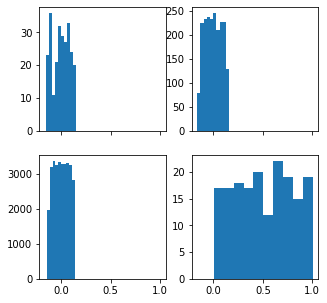

In [13]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [14]:
print(np.array(cnn_model.get_weights())[0].min(),
np.array(cnn_model.get_weights())[1].min(),
np.array(cnn_model.get_weights())[2].min(),
np.array(cnn_model.get_weights())[3].min())

-0.15292138 -0.16302589 -0.1415057 0.006515134


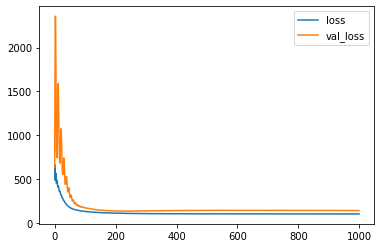

In [15]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

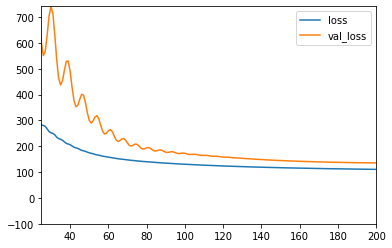

In [16]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.xlim([25,200])
_ = plt.ylim([-100,max(history.history['val_loss'][25:500])])
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [198.382250792,101.9550876699154]
1-step R^2 [Naive, CNN model] = [0.8413462380389802,0.9189215378228291]


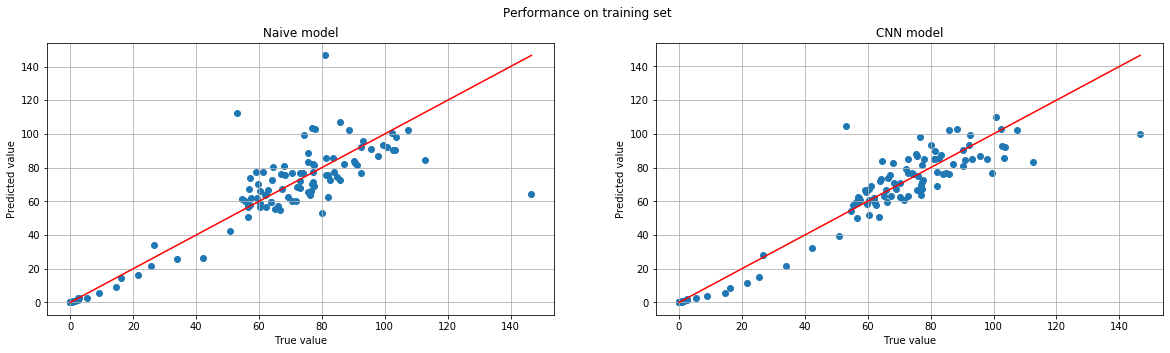

(125,) (125,) (125,)


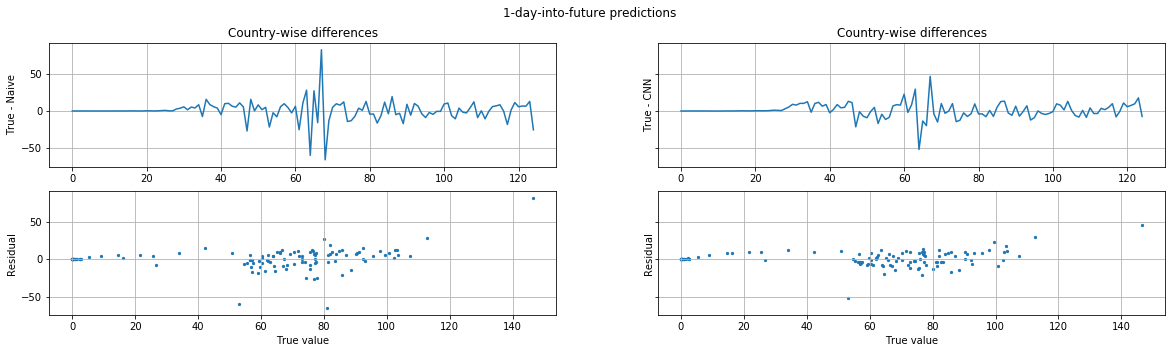

146.612 146.612 109.77705


In [17]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

In [18]:
y_cnn_train_model.max(), y_train_naive.max(), y_predict.max()

(146.612, 146.612, 109.77705)

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,140.5552017675716]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.49625345903389195]


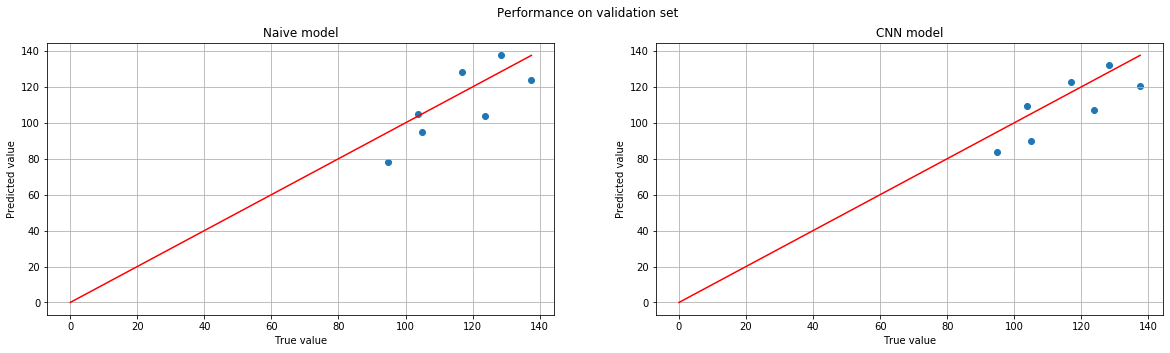

(7,) (7,) (7,)


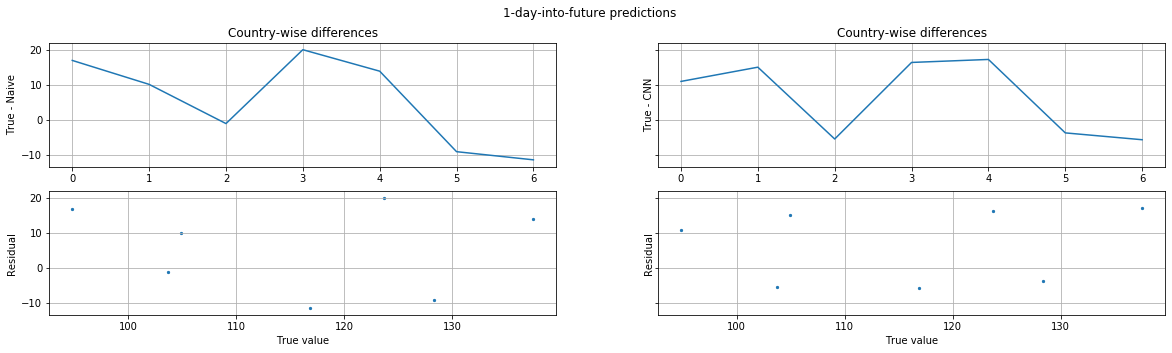

137.543 146.612 132.16919


In [19]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

In [20]:
# train_tile_shape = np.array(np.array(X_cnn_train.shape)/np.array(frame_denom.shape),int)
# minmax_inverse_train = X_train - (((X_cnn_train / 0.5) * np.tile(frame_denom, train_tile_shape)) + np.tile(frame_min, train_tile_shape))


# validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
# minmax_inverse_validate = X_validate - (((X_cnn_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))


# test_tile_shape = np.array(np.array(X_cnn_test.shape)/np.array(latest_denom.shape),int)
# minmax_inverse_test = X_test - (((X_cnn_test / 0.5) * np.tile(latest_denom, test_tile_shape)) + np.tile(latest_min, test_tile_shape))
# print(np.linalg.norm(minmax_inverse_train),np.linalg.norm(minmax_inverse_validate),np.linalg.norm(minmax_inverse_test))

# 2 nonneg

1-step MSE [Naive, CNN model] = [170.80669257142873,390.12602832774525]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.6970863460225101]

# 2 nonneg, pool, relu
There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,13586.662088]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.0]

# 2 nonneg, pool

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,556.4749063236223]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.4443304826760618]


# pool + only 1 nonneg and relu at very end. probably could use more than 1500 epochs

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,476.8907287109961]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5434063478478779]



# negative, pooling, relu at very end

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,256.32871004595506]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.6796489686915346]


# only nonneg and relu at very end.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,138.01389460401262]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5543860897517913]


# only relu at very end.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,140.32871993958562]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5113786900493877]

# 2 dense relu

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,216.5053047822524]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.4716586801209258]

# 2 nonneg, 2 relu

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,396.11096463299015]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.6519816604307848]

# average pooling, relu at very end.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,426.28375726972956]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.6618604718747367]

# elimination round



# 2 nonneg and relu at very end.


# only nonneg and relu at very end.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,139.36171575910947]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5208973986926813]

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,138.42094987360994]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5469134697530336]

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,140.77506300920305]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5274845291582406]

# only  relu at very end.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,140.42387636891903]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5162934749412229]

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,141.2069144587355]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5047534149090478]

Time index to X relationship.

    Last frame, last day of X is time_index() - n_days_into_future
    last frame, first day is time_index() - n_days_into_future - frame_size
    first frame, first day is start_date-frame_size
    first frame, last day is start_date


Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.
The "missing" data point at the end is because it is in the prediction variable y, and not in X.

At first the following plot looks wrong because y looks like it is 1-day behind but this is only because I am
not providing the time values. I.e. the 5th value of y is actually the 6th value of X. 

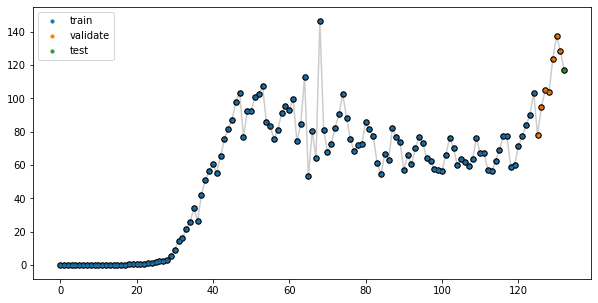

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_train)), X_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_train), len(X_train)+len(X_validate)), X_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_train)+len(X_validate), len(X)), X_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
ax.plot(data[data.location=='United States'].new_cases_per_million.values[frame_size-1:-1], color='k',alpha=0.2)
plt.legend()
_ = plt.show()
# plt.plot(X_validate[:,0,-1,:])

# Regression


In [22]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
r_data = r_data[r_data.location == 'United States']

I only use 1 feature in the CNN model, I understand that regression and CNN are fundamentally different but does
this mean I should only be using 1 feature for a fair baseline comparison?

In [23]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[r_data.time_index >= first_day]
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
#
new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [24]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [25]:
validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
X_validate - (((X_cnn_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))
(latest_max, latest_min, latest_denom) = latest_minmax

In [26]:
print(X_regression_train.max(),X_regression_validate.max(),X_regression_test.max())

146.612 137.543 137.543


In [27]:
print(X_regression_train.shape,X_regression_validate.shape,X_regression_test.shape)

(125, 28) (7, 28) (1, 28)


In [28]:
print(y_regression_train.shape,y_regression_validate.shape,y_regression_test.shape)

(125,) (7,) (1,)


Each row is a frame of frame_size days of new_cases_per_million data for a single country. So the number of rows equals
n_countries times frame_size

This transformation (slicing off last row) is because X_regression is both training and validation
data to be sliced by the train, validation indices passed to Ridge CV. i.e. the holdout set is being held out.

In [29]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [198.382250792,100.32805106976801]
1-step R^2 [Naive, Ridge regression model] = [0.8413462380389802,0.9196921269889909]


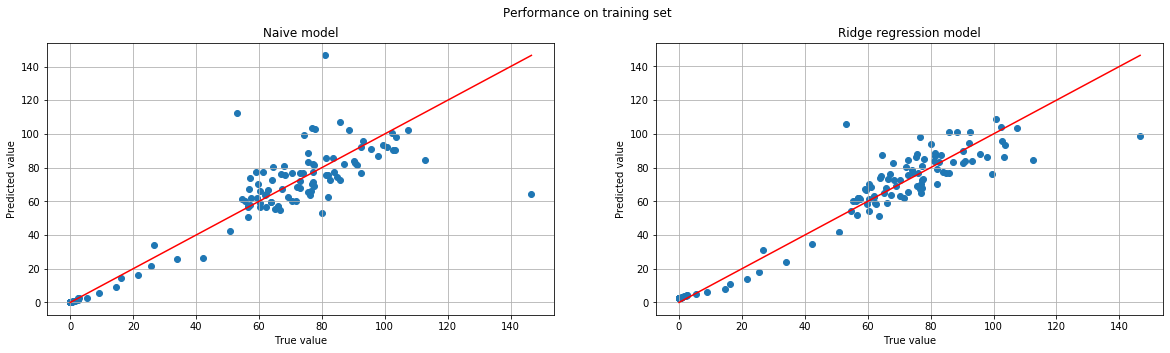

(125,) (125,) (125,)


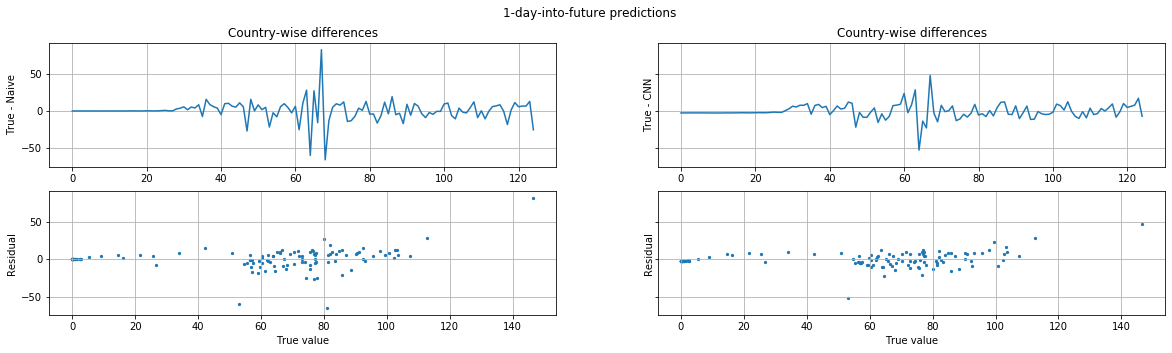

In [30]:
y_predict_train = regression_model.predict(X_regression_train).ravel()

model_analysis( y_regression[train_indices].ravel(), y_train_naive, y_predict_train, 
               n_countries, title='Ridge regression model', suptitle='Performance on training set')

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [170.80669257142873,111.08086446025358]
1-step R^2 [Naive, Ridge regression model] = [0.2994526992709322,0.6146030489864923]


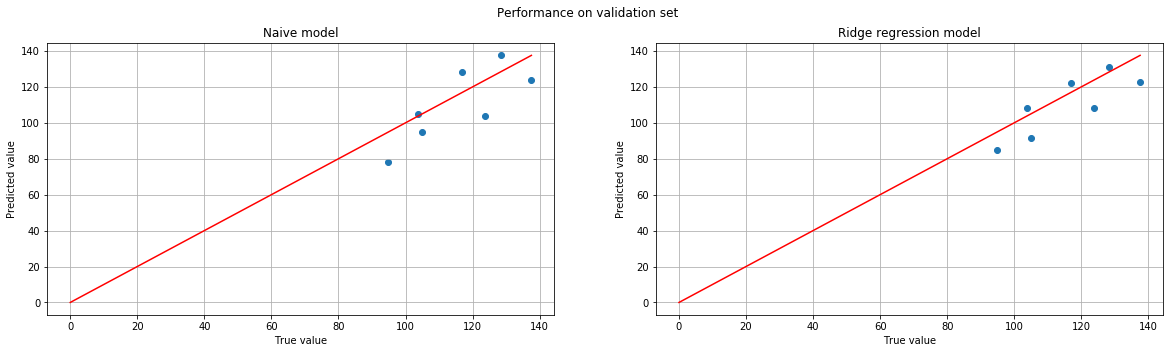

(7,) (7,) (7,)


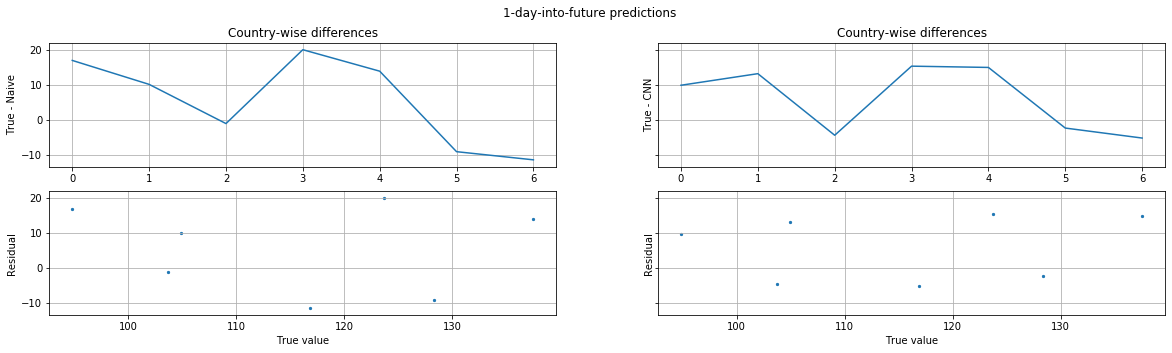

In [31]:
y_predict_validate = regression_model.predict(X_regression_validate).ravel()
model_analysis( y_regression_validate.ravel(), y_validate_naive, y_predict_validate, n_countries,title='Ridge regression model', suptitle='Performance on validation set')

# scaled single feature

In [32]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[r_data.time_index >= first_day]
# r_model_data = r_data.new_cases_per_million.apply(lambda x : np.log(x+1)).to_frame().copy(); new_cases_index=0
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [33]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [34]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)

(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax

(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = scaled_splits



In [35]:
train_tile_shape = np.array(np.array(X_regression_train.shape) / np.array(frame_denom.shape),int)
minmax_inverse_train = X_train - (((X_regression_train / 0.5) * np.tile(frame_denom, train_tile_shape)) + np.tile(frame_min, train_tile_shape))
np.linalg.norm(minmax_inverse_train)

1.891701305027451e-13

In [36]:
validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
minmax_inverse_validate = X_validate - (((X_regression_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))
np.linalg.norm(minmax_inverse_validate)

7.78360568894479e-14

In [37]:
test_tile_shape = np.array(np.array(X_regression_test.shape)/np.array(latest_denom.shape),int)
minmax_inverse_test = X_test - (((X_regression_test / 0.5) * np.tile(latest_denom, test_tile_shape)) + np.tile(latest_min, test_tile_shape))
np.linalg.norm(minmax_inverse_test)

3.1776437161565096e-14

In [38]:
flat_splits = flatten_Xy_splits(scaled_splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

There were 3 negative predictions
1-step MSE [Naive, Ridge] = [198.382250792,356.78679259656167]
1-step R^2 [Naive, Ridge] = [0.8413462380389802,0.7165900210578352]


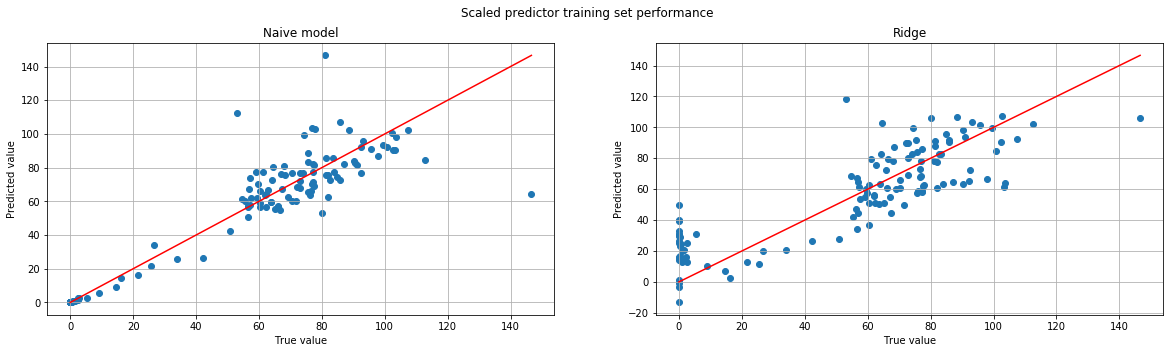

(125,) (125,) (125,)


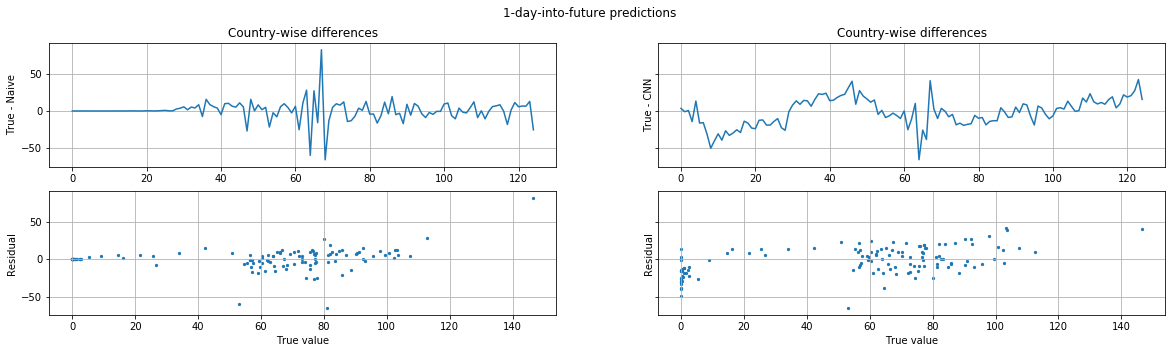

In [39]:
y_predict_train = regression_model.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, title='Ridge', suptitle='Scaled predictor training set performance')

There were 0 negative predictions
1-step MSE [Naive, Ridge] = [170.80669257142873,1052.0112992530428]
1-step R^2 [Naive, Ridge] = [0.2994526992709322,0.6857095601437939]


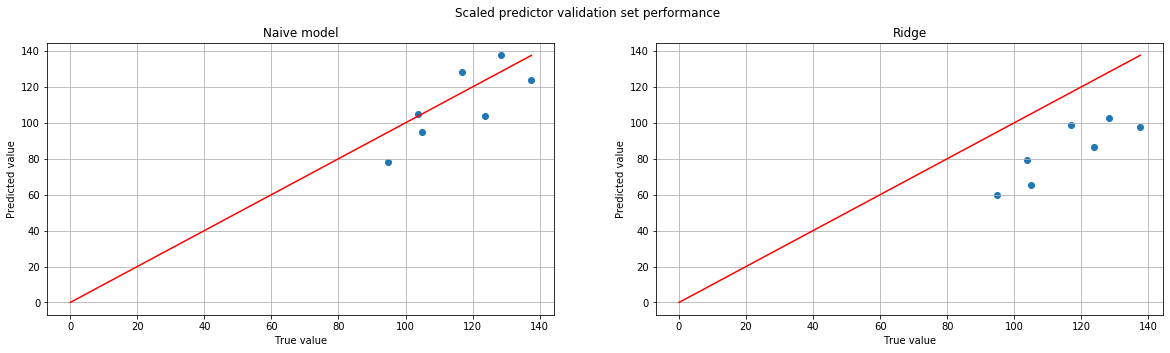

(7,) (7,) (7,)


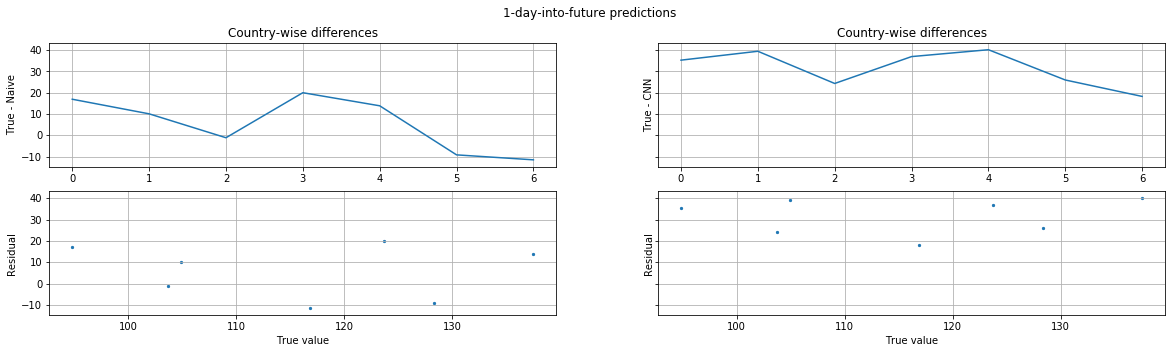

In [40]:
y_predict_validate = regression_model.predict(X_regression_validate).ravel()
model_analysis(y_regression_validate, y_validate_naive, y_predict_validate, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

# "All" feature prediction

In [41]:
# n_prune = 2
# mae_list_naive = []
# r2_list_naive = []
# mae_list_predict = []
# r2_list_predict = []
# # data = data[r_data.time_index >= first_day]
# new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
# n_countries = r_data.location.nunique()
# target_data = r_data.new_cases_per_million
# time_index = r_data.time_index
# frame_size = 28
# start_date = 2*frame_size #+ time_index.min()
# # start_date = 50
# n_validation_frames = 7
# n_test_frames = 1
# n_days_into_future = 1
# train_or_test = 'train'


n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
r_model_data = r_data.iloc[:,2:].copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [42]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [43]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)

(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax

To ensure that there is no time pollution going on, look at the first and last rows of the training data to ensure
that they have the correct days.

In [44]:
flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

In [45]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
new_cases_indices = np.ravel_multi_index([list(range(frame_size)),[new_cases_index]],(frame_size, n_features))
new_cases_indices

array([  2,  24,  46,  68,  90, 112, 134, 156, 178, 200, 222, 244, 266,
       288, 310, 332, 354, 376, 398, 420, 442, 464, 486, 508, 530, 552,
       574, 596], dtype=int64)

In [46]:
# The first frame should have time values from 0 to 27.
r_model_data.new_cases_per_million.iloc[:28].values-X_regression_train[0, new_cases_indices]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [47]:
# The last row or last frame, should have values from time_index.max()-1-n_test_frames-n_validation_frames-frame_size to time_index.max()-1-n_test_frames-n_validation_frames
(r_model_data.new_cases_per_million.iloc[-28-n_test_frames-n_validation_frames-1:-n_test_frames-n_validation_frames-1].values
 -X_regression_train[-1, new_cases_indices])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

There were 8 negative predictions
1-step MSE [Naive, Ridge] = [198.382250792,1.5857987096039372]
1-step R^2 [Naive, Ridge] = [0.8413462380389802,0.9987292889761479]


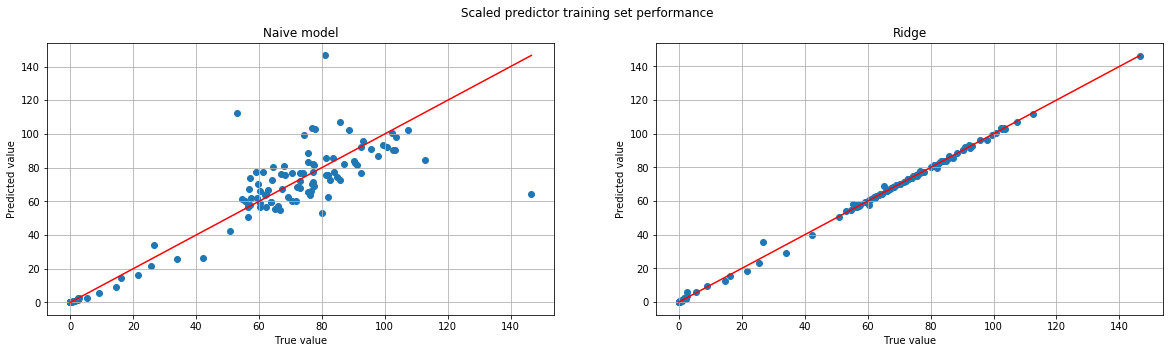

(125,) (125,) (125,)


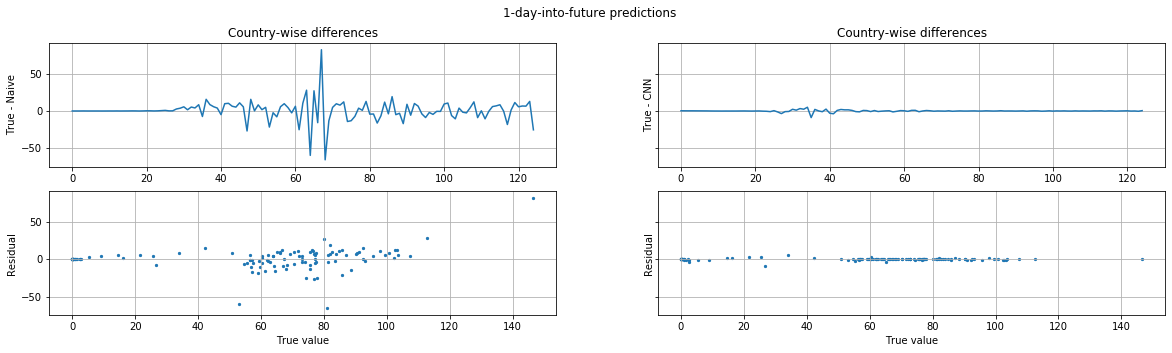

In [48]:
y_predict_train = regression_model.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, title='Ridge', suptitle='Scaled predictor training set performance')

There were 0 negative predictions
1-step MSE [Naive, Ridge] = [170.80669257142873,0.043531827679544964]
1-step R^2 [Naive, Ridge] = [0.2994526992709322,0.999784042888764]


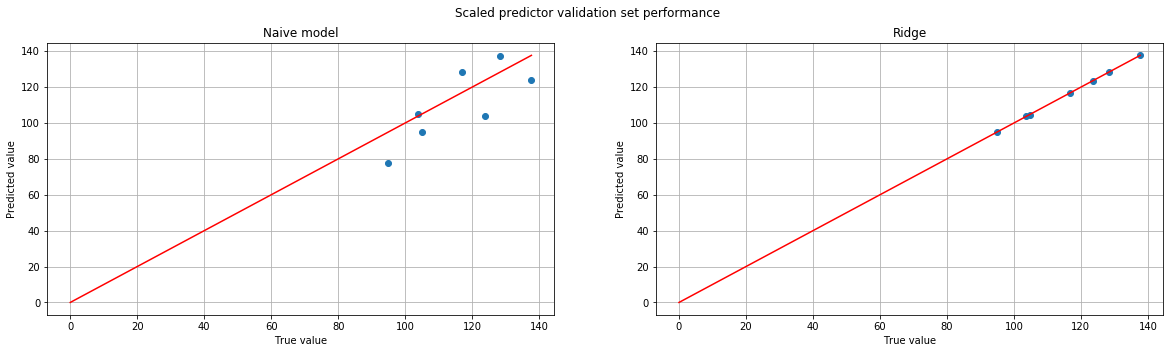

(7,) (7,) (7,)


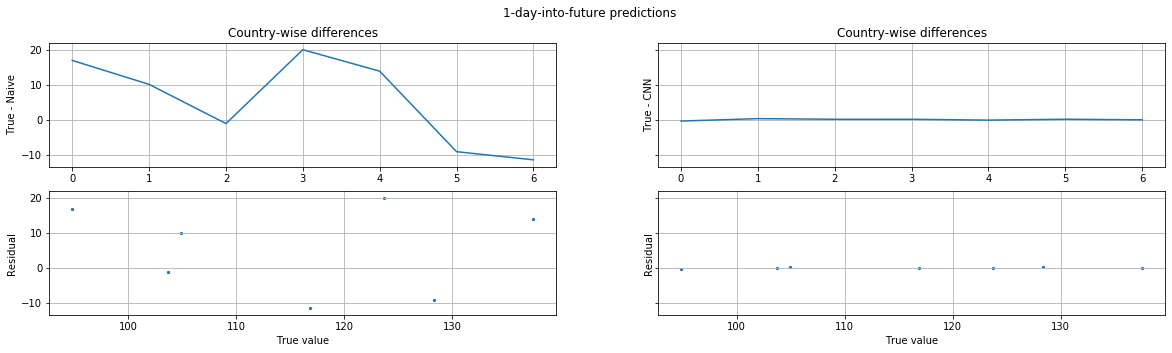

In [49]:
y_predict_validate = regression_model.predict(X_regression_validate).ravel()
model_analysis(y_regression_validate, y_validate_naive, y_predict_validate, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

# Final predictions for comparison

In [50]:
y_naive = y_test_naive
y_true = y_test
y_predict_r = regression_model.predict(X_regression_test)
y_predict_c = cnn_model.predict(X_cnn_test_model)

In [51]:
y_naive, y_true 

(array([116.836]), array([[125.546]]))

In [52]:
y_predict_r, y_predict_c

(array([211.61576065]), array([[123.25208]], dtype=float32))

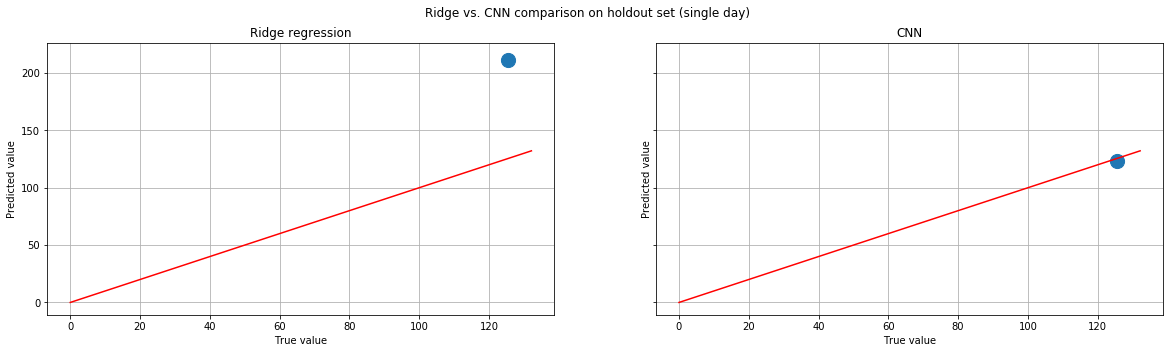

In [53]:
s = 200
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5),sharey=True)

ymax = np.max([y_true.max(), y_predict.max()])
ax1.plot([0, ymax], [0, ymax],color='r')
ax1.scatter(y_true, y_predict_r, s=s)
ax2.plot([0, ymax], [0, ymax],color='r')
ax2.scatter(y_true, y_predict_c, s=s)

ax1.set_xlabel('True value')
ax1.set_ylabel('Predicted value')
ax1.set_title('Ridge regression')

ax2.set_xlabel('True value')
ax2.set_ylabel('Predicted value')
ax2.set_title('CNN')
ax1.grid(True)
ax2.grid(True)
plt.suptitle('Ridge vs. CNN comparison on holdout set (single day)')
plt.show()